In [1]:
"""Libraries"""

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import os
import pandas as pd
import importlib

# my own file:
import diffeq as de
importlib.reload(de)

<module 'diffeq' from 'F:\\OneDrive - Budapesti Műszaki és Gazdaságtudományi Egyetem\\TDK\\diffeq.py'>

In [56]:
"""Read files"""

parameters = ['R_E', 'R_0/R_E', 'P_inf', 'alfa_M', 'T_inf', 'vapour pressure', 'index', 'surfactant',]
parameters_with_units = ['R_E [m]', 'R_0/R_E [-]', 'P_inf [Pa]', 'alfa_M [-]', 'T_inf [K]', 'vapour pressure [Pa]', 'index [Ar: 9; He: 10]', 'surfactant [-]',]
parameter_ranges = []

study_name = 'full study try 3'
file_format = '.csv'
file_base_name = 'output_'
seperator = ','
line_end = '\n'

# Prints parameters of each line to be copied into code
def print_as_list(df):
    print('[')
    string = '    # ID, '
    for parameter in parameters:
        string += parameter +', '
    print(string)
    for index, line in df.iterrows():
        string = '    ['
        for parameter in ['ID'] + parameters:
            string += str(line[parameter]) + ', '
        string += '\b\b],    # error code=' + str(line['error code']) + ';   Energy=' + str(line['Energy']) + ' [MJ/kg]'
        print(string)
    print(']')

# create a list of file and sub directories 
# names in the given directory 
def listAllFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = []
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + listAllFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

# Load all files
parent_dir = os.getcwd()
save_dir = os.path.join(parent_dir, study_name)
all_files = listAllFiles(save_dir)
all_data = pd.DataFrame()
print(f'Found files:')
for file in all_files:
    name = os.path.basename(file)
    if name[-len(file_format):] == file_format and name[:len(file_base_name)] == file_base_name:
        df = pd.read_csv(file)
        
        print(f'\t{name}\t({df.shape[0]} rows)')
        all_data = pd.concat([all_data, df])

# Rename columns ('runtime [s]' --> 'runtime')
for old_name in all_data.columns:
    new_name = old_name
    if old_name.find(' [') != -1:
        new_name = old_name[:old_name.find(' [')]
    all_data.rename(columns = {old_name:new_name}, inplace = True)

# Get valid datas
good_data = all_data.loc[
    ((all_data['error code'] == 0) | (all_data['error code'] == 1)) &
    #((all_data['T_max'] < 6000.0) & (1250.0 < all_data['T_max'])) &
    (all_data['Energy'] > 0.0) & (all_data['Energy'] == all_data['Energy']) # positive not NaN
]

wrong_data = all_data.loc[
    (all_data['error code'] == 2) | (all_data['T_max'] >= 6000.0)
]
# Sort by energy
#good_data.loc[good_data['Energy'] < 0.0, 'Energy'] = 1e10
#good_data.loc[good_data['Energy'] != good_data['Energy'], 'Energy'] = 1e10
good_data = good_data.sort_values(['Energy'], ascending=True)
good_data['logE'] = np.log10(good_data['Energy'])

print(f'_______________________________________')
total = all_data.shape[0]
print(f'total:  {total} rows   (100 %)')
num = all_data.loc[(all_data['error code'] == 1)].shape[0]
print(f'error1: {num} rows   ({(100*num/total):.2f} %)')
num = all_data.loc[(all_data['error code'] == 2)].shape[0]
print(f'error2: {num} rows   ({100*num/total:.2f} %)')
num = all_data.loc[(all_data['T_max'] > 6000.0)].shape[0]
print(f'too hot: {num} rows    ({100*num/total:.2f} %)')
num = good_data.shape[0]
print(f'good:   {num} rows   ({100*num/total:.2f} %)')
print(f'_______________________________________')

# Parameter ranges
for (parameter, parameter_with_unit) in zip(parameters, parameters_with_units):
    parameter_ranges.append( np.sort(good_data[parameter].unique()) )
    print(f'{parameter_with_unit} range: {parameter_ranges[-1]}   ({len(parameter_ranges[-1])} piece)')

Found files:
	output_0.csv	(20000 rows)
	output_1.csv	(20000 rows)
	output_10.csv	(20000 rows)
	output_11.csv	(20000 rows)
	output_12.csv	(20000 rows)
	output_13.csv	(20000 rows)
	output_14.csv	(20000 rows)
	output_15.csv	(20000 rows)
	output_16.csv	(20000 rows)
	output_17.csv	(20000 rows)
	output_18.csv	(20000 rows)
	output_19.csv	(20000 rows)
	output_2.csv	(20000 rows)
	output_20.csv	(20000 rows)
	output_21.csv	(20000 rows)
	output_22.csv	(20000 rows)
	output_23.csv	(20000 rows)
	output_24.csv	(20000 rows)
	output_25.csv	(20000 rows)
	output_26.csv	(20000 rows)
	output_27.csv	(20000 rows)
	output_28.csv	(20000 rows)
	output_29.csv	(20000 rows)
	output_3.csv	(20000 rows)
	output_30.csv	(20000 rows)
	output_31.csv	(20000 rows)
	output_32.csv	(20000 rows)
	output_33.csv	(20000 rows)
	output_34.csv	(20000 rows)
	output_35.csv	(20000 rows)
	output_36.csv	(20000 rows)
	output_37.csv	(20000 rows)
	output_38.csv	(20000 rows)
	output_39.csv	(20000 rows)
	output_4.csv	(20000 rows)
	output_40.c

In [8]:
"""Correct energy"""

def Work(R_E, ratio, P_inf, T_inf, P_v, surfactant, index):
    R_star = ratio * R_E
    V_E = 4.0 / 3.0 * R_E**3 * np.pi    # [m^3]
    V_star = 4.0 / 3.0 * R_star**3 * np.pi  # [m^3]
    
    p_E = P_inf + 2 * surfactant * de.par_sigma / R_E # Pa
    p_gas = p_E - P_v
    n_gas = p_gas * V_E / (de.par_R_g * T_inf)
    
    W_star = P_v * V_star + n_gas * de.par_R_g * T_inf * np.log(V_star) + 4.0 * np.pi * de.par_sigma * surfactant * R_star**2
    W_E = P_v * V_E + n_gas * de.par_R_g * T_inf * np.log(V_E) + 4.0 * np.pi * de.par_sigma * surfactant * R_E**2
    return W_star - W_E    # J

good_data['Work'] = Work(good_data['R_E'], good_data['R_0/R_E'], good_data['P_inf'], good_data['T_inf'], good_data['vapour pressure'], good_data['surfactant'], good_data['index'])
good_data['m_H2'] = 1e-3 * good_data['n_H2'] / de.par_W[2]    # [kg]
good_data['Energy'] = 1e-6 * good_data['Work'] / good_data['m_H2']    # [MJ/kg]
good_data = good_data.sort_values(['Energy'], ascending=True)

In [9]:
"""Dataframe"""

good_data[['ID', 'error code', 'steps', 'runtime', 'T_max', 'collapse time', 'n_H2', 'n_O2',
       'Work', 'Energy', 'R_E', 'R_0/R_E', 'P_inf', 'alfa_M',
       'T_inf', 'index', 'surfactant']].describe()

,ID,error code,steps,runtime,T_max,collapse time,n_H2,n_O2,Work,Energy,R_E,R_0/R_E,P_inf,alfa_M,T_inf,index,surfactant
count,60326.0,60326.000000,6.032600e+04,60326.000000,60326.000000,6.032600e+04,6.032600e+04,6.032600e+04,6.032600e+04,6.032600e+04,6.032600e+04,60326.000000,6.032600e+04,60326.000000,60326.000000,60326.0,60326.000000
mean,0.0,0.029241,1.896170e+04,9.068742,4649.930087,1.702544e-06,3.034406e-13,1.507609e-13,6.864060e-07,1.953394e+28,6.766565e-06,16.485609,5.222238e+06,0.115885,304.125086,9.0,0.596366
std,0.0,0.168483,4.444131e+04,27.026673,1396.738630,2.499350e-06,9.754203e-13,4.853363e-13,1.907126e-06,4.089913e+30,7.989914e-06,8.109186,2.466019e+06,0.084603,11.554342,0.0,0.225274
min,0.0,0.000000,2.531000e+03,0.593750,733.686196,5.630298e-09,1.972818e-46,-1.442673e-19,2.228183e-13,8.673058e+03,1.003092e-07,1.544916,5.198866e+04,0.050014,278.204582,9.0,0.250015
25%,0.0,0.000000,1.171425e+04,3.281250,3897.255943,2.169016e-07,3.799401e-16,1.876197e-16,5.142230e-10,1.648456e+04,1.155986e-06,9.210198,3.234838e+06,0.052244,296.225592,9.0,0.374579
50%,0.0,0.000000,1.503000e+04,4.531250,4303.904133,7.077679e-07,4.575054e-15,2.266789e-15,6.906604e-09,2.334986e+04,2.774336e-06,16.539933,5.582959e+06,0.079551,303.805703,9.0,0.603921
75%,0.0,0.000000,1.841600e+04,6.125000,4979.005283,2.365869e-06,8.148477e-14,4.040439e-14,2.378661e-07,3.875762e+04,1.041349e-05,23.167741,7.103244e+06,0.149201,314.297027,9.0,0.781895
max,0.0,1.000000,6.807550e+06,2805.406250,24510.397079,7.938583e-05,1.723115e-11,8.581723e-12,2.772292e-05,9.969358e+32,2.998491e-05,29.999912,9.997757e+06,0.398809,323.131084,9.0,0.999624


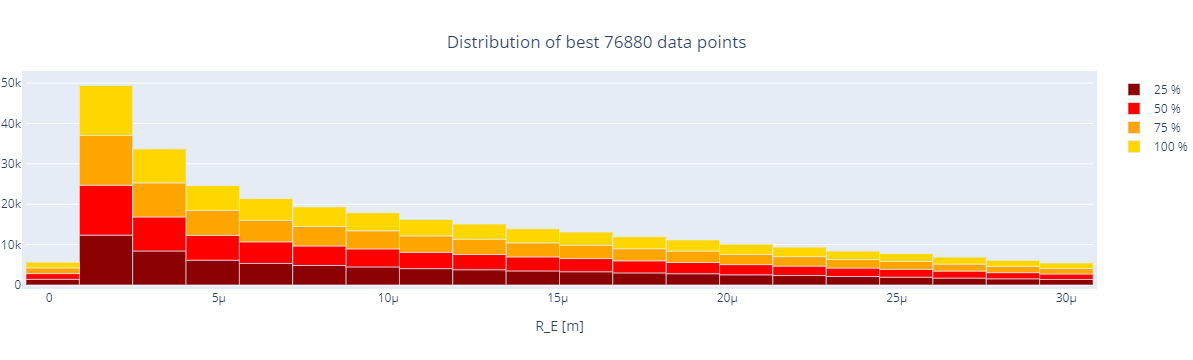

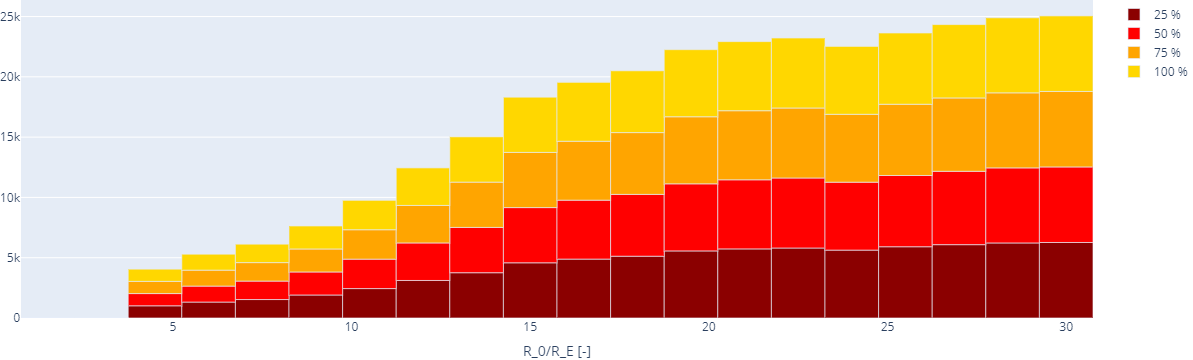

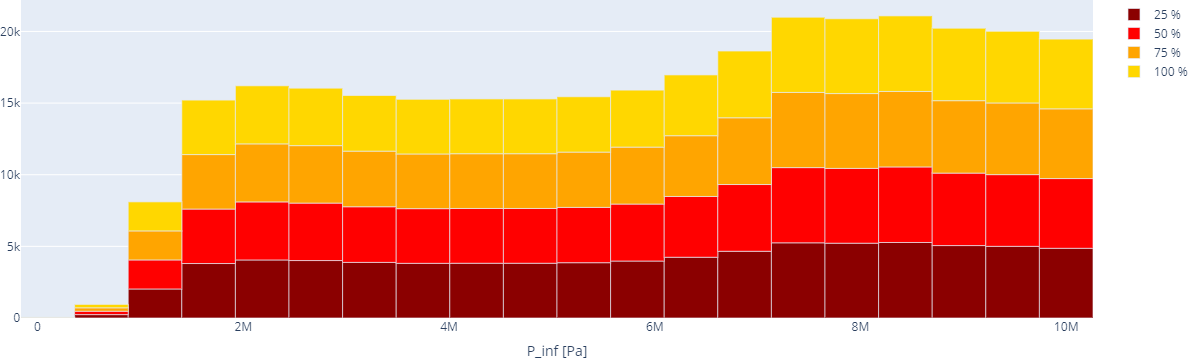

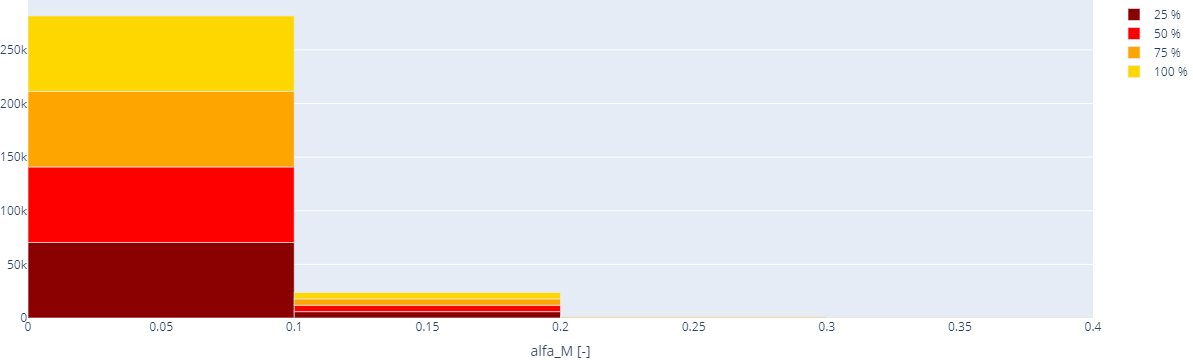

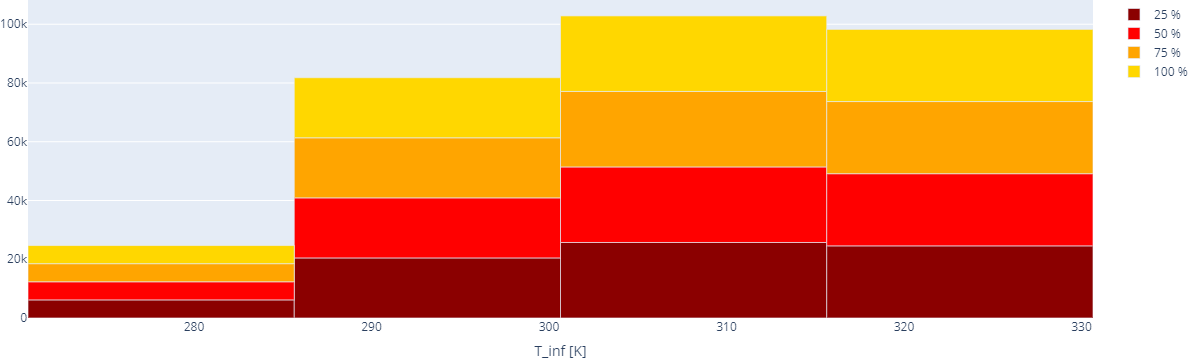

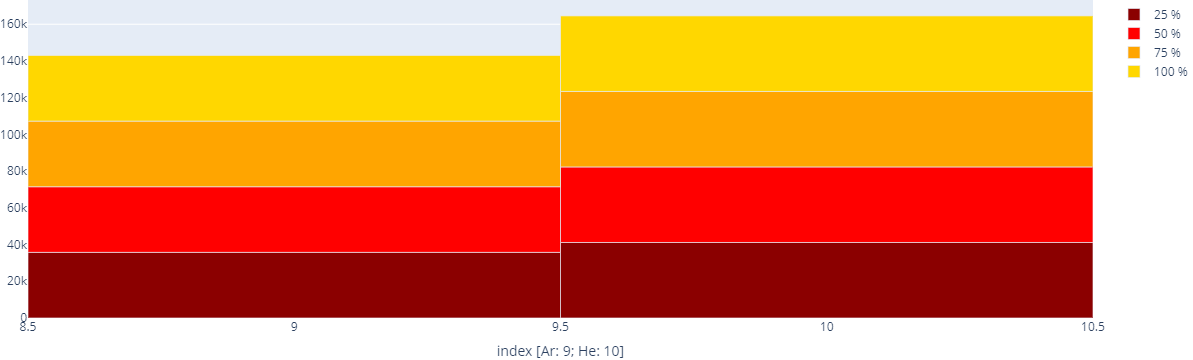

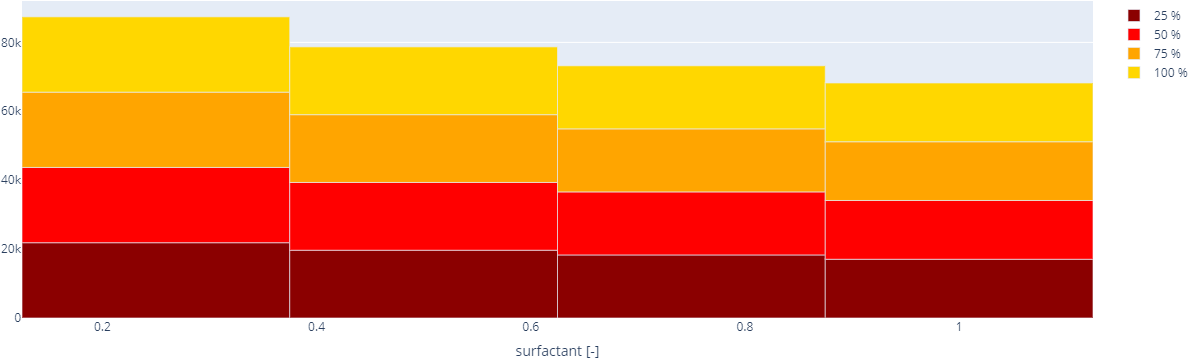

In [24]:
disp = good_data.loc[good_data['Energy']<30e3]
def count(parameter, parameter_range, disp):
    counts = []
    for p in parameter_range:
        counts.append(
            len(disp.loc[(abs(disp[parameter]-p)<1e-9)]),
        )
    return counts

def histogram(disp, parameter, parameter_range, label=None, title=False):
    fig = go.Figure()
    
    counts = count(parameter, parameter_range, disp[0:int(0.25*num)])
    fig.add_trace(go.Bar(y=counts, x=parameter_range, name='25 %', marker=dict(color='darkred')))
    counts = count(parameter, parameter_range, disp[0:int(0.5*num)])
    fig.add_trace(go.Bar(y=counts, x=parameter_range, name='50 %', marker=dict(color='red')))
    counts = count(parameter, parameter_range, disp[0:int(0.75*num)])
    fig.add_trace(go.Bar(y=counts, x=parameter_range, name='75 %', marker=dict(color='orange')))
    counts = count(parameter, parameter_range, disp[0:int(1*num)])
    fig.add_trace(go.Bar(y=counts, x=parameter_range, name='100 %', marker=dict(color='gold')))
    
    if label==None:
        label = parameter
    fig.update_layout(
        xaxis_title=label,
        barmode='relative',
        margin=go.layout.Margin(l=0, r=0, b=0, t=0, pad=0),
        height=200,
        width=1000,
        bargap=0
    )
    
    if title:
        fig.update_layout(
            title={
                'text': f'Distribution of best {disp.shape[0]} data points',
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top',
            },
            margin=go.layout.Margin(l=0, r=0, b=75, t=75, pad=4),
            height=300,
        )
    fig.show()
    
#parameters_latex = ['$R_E\ [m]$', '$R_0/R_E\ [-]$', '$P_\infty\ [Pa]$', '$α_M\ [-]$', '$T_\infty \ [K]$', '$P_v\ [Pa]$', '$index\ [Ar:\ 9;\ He:\ 10]$', '$surfactant\ [-]$',]
title=True
for i in range(len(parameters)):
    if parameters[i]=='vapour pressure':
        continue
    histogram(disp, parameters[i], parameter_ranges[i], label=parameters_with_units[i], title=title)
    title=False

In [22]:
"""Histograms"""
"""
disp = good_data.loc[good_data['Energy']<30e3]

def histogram(disp, col, label=None, nbins=10, title=False):  
    num = disp.shape[0]
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=disp[col][0:int(0.25*num)], name='25 %', marker=dict(color='darkred'), nbinsx=nbins))
    fig.add_trace(go.Histogram(x=disp[col][0:int(0.5*num)], name='50 %', marker=dict(color='red'), nbinsx=nbins))
    fig.add_trace(go.Histogram(x=disp[col][0:int(0.75*num)], name='75 %', marker=dict(color='orange'), nbinsx=nbins))
    fig.add_trace(go.Histogram(x=disp[col][0:int(1*num)], name='100 %', marker=dict(color='gold'), nbinsx=nbins))

    if label==None:
        label = col
    fig.update_layout(
        xaxis_title=label,
        barmode='relative',
        margin=go.layout.Margin(l=0, r=0, b=0, t=0, pad=0),
        height=325,
        width=1000,
    )
    if title:
        fig.update_layout(
            title={
                'text': f'Distribution of best {num} datas',
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top',
            },
            margin=go.layout.Margin(l=0, r=0, b=75, t=75, pad=4),
            height=400,
        )
    fig.show()

title=True
for i in range(len(parameters)):
    histogram(disp, parameters[i], parameters_with_units[i], len(parameter_ranges[i]), title)
    title=False"""
0

0

[
    # ID, R_E, R_0/R_E, P_inf, alfa_M, T_inf, vapour pressure, index, surfactant, 
    [20.0, 4.020202020202021e-07, 30.0, 10000000.0, 0.05, 323.15, 12349.40351028322, 9.0, 0.25],    # error code=0.0;   Energy=8467.707422516374 [MJ/kg]
    [16.0, 4.020202020202021e-07, 29.71212121212121, 10000000.0, 0.05, 323.15, 12349.40351028322, 9.0, 0.25],    # error code=0.0;   Energy=8491.917550864762 [MJ/kg]
    [12.0, 4.020202020202021e-07, 29.424242424242426, 10000000.0, 0.05, 323.15, 12349.40351028322, 9.0, 0.25],    # error code=0.0;   Energy=8516.808853575105 [MJ/kg]
    [8.0, 4.020202020202021e-07, 29.13636363636364, 10000000.0, 0.05, 323.15, 12349.40351028322, 9.0, 0.25],    # error code=0.0;   Energy=8542.39770165366 [MJ/kg]
    [4.0, 4.020202020202021e-07, 28.84848484848485, 10000000.0, 0.05, 323.15, 12349.40351028322, 9.0, 0.25],    # error code=0.0;   Energy=8568.700500761768 [MJ/kg]
    [0.0, 4.020202020202021e-07, 28.560606060606066, 10000000.0, 0.05, 323.15, 12349.40351028322, 9.

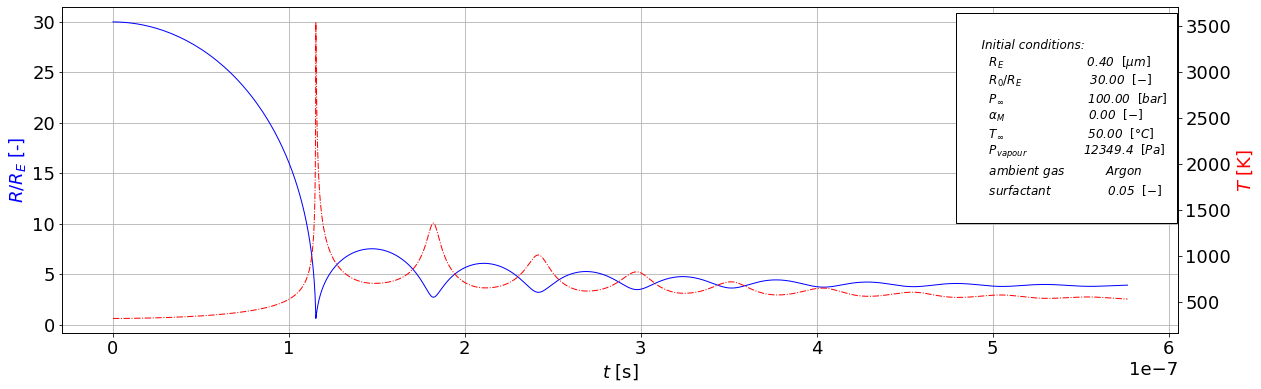

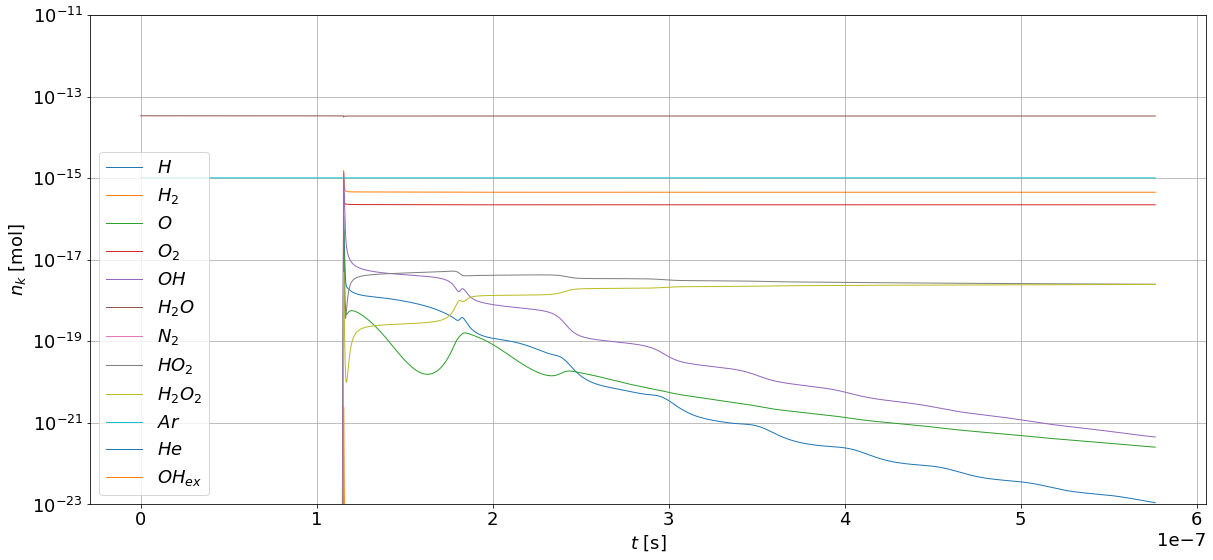

ID:                      0
error code [0; 1; 2]:    0
steps [-]:               13389
runtime [s]:             1.796875
R_E [m]:                 4.020202020202021e-07
R_0/R_E [-]:             30.0
P_inf [Pa]:              10000000.0
alfa_M [-]:              0.0
T_inf [K]:               323.15
vapour pressure [Pa]:    12349.40351028322
index [Ar: 9; He: 10]:   9.0
surfactant [-]:          0.05
T_max [K]:               3544.139677722589
collapse time [s]:       1.1532188287142862e-07
n_H2 [mol]:              4.500890007229811e-16
n_O2 [mol]:              2.2318640678984734e-16
Work [Joule]:            1.2510201702733504e-10
Energy [MJ/kg]:          4447.1921536010095
R_last [m]:              1.3093151411215146e-06
R_dot_last:              1.5607779773571175e-16
T_last [k]:              323.1500000000747
c_H [mol/cm^3]:          6.500818921228134e-25
c_H2 [mol/cm^3]:         4.787152030214985e-05
c_O [mol/cm^3]:          1.0470510137670673e-25
c_O2 [mol/cm^3]:         2.373813309510304e-05

In [55]:
"""Plot 1 solution"""

print_as_list(good_data[:10])
de.plot( [20.0, 4.020202020202021e-07, 30.0, 10000000.0, 0.0, 323.15, 12349.40351028322, 9.0, 0.05] )
# [0.0, 1.6736842105263158e-06, 30.0, 10000000.0, 0.05, 323.15, 12349.40351028322, 9.0, 0.25]
# [0.0, 4.045621302769317e-07, 29.948877815255923, 8999916.500369592, 0.05011823420486024, 322.54426787856244, 11982.847622396348, 9.0, 0.25]

In [5]:
"""Wrong datas"""
"""
disp = all_data.loc[
    #(all_data['error code'] == 1)
    (all_data['error code'] == 2)
    #(all_data['T_max'] > 6000.0)
]

markers = ['circle', 'square', 'diamond']
symbols = [markers[i] for i in disp['error code']]

data=[go.Scatter3d(
    x=disp['R_E'],
    y=disp['R_0/R_E'],
    z=disp['T_inf'],
    mode='markers',
    showlegend=False,
    textposition='top center',
    marker=dict(
        size=5,
        symbol=symbols,
        color=disp['alfa_M'],
        colorscale='Plasma',
        showscale=True,
        colorbar_title='alfa_M [-]',
        cmin=parameter_ranges[3][0], cmax=parameter_ranges[3][-1],
    ),
)]

layout = go.Layout(
    autosize=False,
    width=1000, height=600,
    margin=go.layout.Margin(
        l=0,
        r=0,
        b=0,
        t=50,
        pad = 4
    ),
)

fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    title={
        'text': "Wrong datas",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    scene = dict(
        xaxis = dict(title='R_E [m]', range=[parameter_ranges[0][0], parameter_ranges[0][-1]]),
        yaxis = dict(title='R_0/R_E [-]', range=[parameter_ranges[1][0], parameter_ranges[1][-1]]),
        zaxis = dict(title='T_inf [K]', range=[parameter_ranges[4][0], parameter_ranges[4][-1]]),
    ),
)
fig.show()
"""
0

0

In [64]:
"""Best datas"""
"""
disp = good_data[:10000]

markers = ['circle', 'square', 'diamond']
symbols = [markers[i] for i in disp['error code']]

data=[go.Scatter3d(
    x=disp['R_E'],
    y=disp['R_0/R_E'],
    z=disp['T_inf'],
    mode='markers',
    showlegend=False,
    textposition='top center',
    marker=dict(
        size=5,
        symbol=symbols,
        color=disp['logE'],
        colorscale='Plasma',
        showscale=True,
        colorbar_title='log_10(Energy [MJ/kg])',
        cmin=4, cmax=6,
        opacity=1,
        line_width=0
    ),
)]

layout = go.Layout(
    autosize=False,
    width=1000, height=600,
    margin=go.layout.Margin(
        l=0,
        r=0,
        b=0,
        t=50,
        pad = 4
    ),
)

fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    title={
        'text': "Best datas",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    scene = dict(
        xaxis = dict(title='R_E [m]', range=[parameter_ranges[0][0], parameter_ranges[0][-1]]),
        yaxis = dict(title='R_0/R_E [-]', range=[parameter_ranges[1][0], parameter_ranges[1][-1]]),
        zaxis = dict(title='T_inf [K]', range=[parameter_ranges[4][0], parameter_ranges[4][-1]]),
    ),
)
fig.show()
"""
0

0

E=15000.0 MJ/kd -->  0.549 %
E=20000.0 MJ/kd -->  2.525 %
E=25000.0 MJ/kd -->  5.539 %
E=30000.0 MJ/kd -->  8.620 %
E=35000.0 MJ/kd -->  11.151 %
E=40000.0 MJ/kd -->  13.530 %
E=45000.0 MJ/kd -->  15.883 %
E=50000.0 MJ/kd -->  18.309 %
E=55000.0 MJ/kd -->  20.866 %
E=60000.0 MJ/kd -->  23.527 %
E=65000.0 MJ/kd -->  26.016 %
E=70000.0 MJ/kd -->  28.319 %
E=75000.0 MJ/kd -->  30.542 %
E=80000.0 MJ/kd -->  32.791 %
E=85000.0 MJ/kd -->  35.037 %
E=90000.0 MJ/kd -->  37.326 %
E=95000.0 MJ/kd -->  39.584 %
E=100000.0 MJ/kd -->  41.620 %


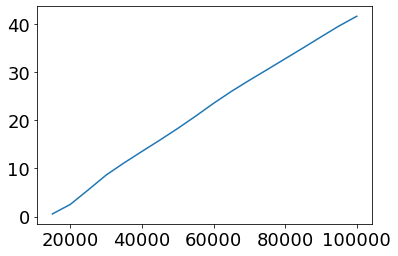

In [72]:
E=np.linspace(15e3, 100e3, 18)
num = len(good_data)
plot = []
for e in E:
    plot.append(100*len(good_data.loc[good_data['Energy']<e])/num)

fig, ax= plt.subplots(figsize=(6, 4))
plt.plot(E, plot)
for e, p in zip(E, plot):
    print(f'E={e} MJ/kd --> {p: .3f} %')

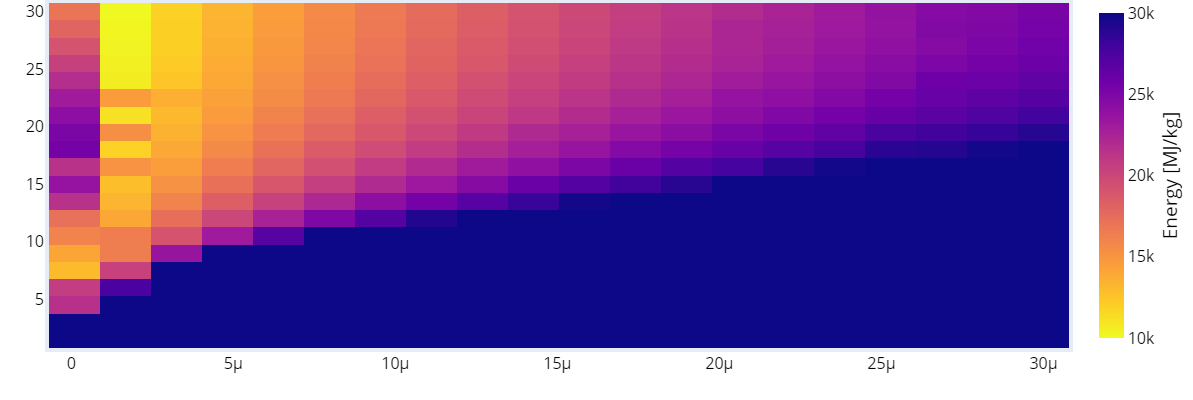

In [30]:
"""2D graph"""

disp = good_data.loc[
    (good_data['R_0/R_E'] > 0.0) &
    (abs(good_data['P_inf'] - 100e5) < 100 ) &
    (good_data['alfa_M'] == 0.05) &
    (good_data['T_inf'] == 323.15) &
    (good_data['index'] == de.par_indexOfArgon) &
    (good_data['surfactant'] == 0.25)
]

"""disp = good_data.loc[
    (good_data['R_0/R_E'] > 0.0) &
    (abs(good_data['P_inf'] - 60e5) < 1e-3 ) &
    (good_data['alfa_M'] == 0.05) &
    (good_data['T_inf'] == 303.15) &
    (good_data['index'] == de.par_indexOfHelium) &
    (good_data['surfactant'] == 0.5)
]"""

data = go.Heatmap(
    x=disp['R_E'],
    y=disp['R_0/R_E'],
    z=disp['Energy'],#-np.log10(disp['Energy']),
    colorscale='Plasma_r',
    zmin=10e3, zmax=30e3,
    connectgaps=True,
    #zsmooth='best',
    colorbar=dict(
            title='Energy [MJ/kg]',
            titleside='right',
            thickness=25,
            thicknessmode='pixels',
            len=1.0,
            lenmode='fraction',
            outlinewidth=0,
            titlefont=dict(color='black', family='Open Sans'),
    )
)

# Layout
layout = go.Layout(
    font=dict(color='black', family='Open Sans', size=16),
    #title_text="Energy required for hydrogen production",
    autosize=False,
    width=500, height=400,
    margin=go.layout.Margin(
        l=0,
        r=0,
        b=0,
        t=0,
        pad = 4
    ),
)

fig = go.Figure(data=data, layout=layout)
fig.update_xaxes(title='$R_E\ [m]$', titlefont=dict(color='black', family='Open Sans', size=16),)
fig.update_yaxes(title='$R_0/R_E \ [-]$', titlefont=dict(color='black', family='Open Sans', size=16),)
fig.show()
fig.write_image("images/2Dplot_globopt.png")

In [52]:
P_inf_to_plot=np.array([  621052.63157895,  1663157.89473684,  2705263.15789474,
        3747368.42105263,  4789473.68421053,  5831578.94736842,
        6873684.21052632,  7915789.47368421,  8957894.73684211,
       10000000.        ])
len(P_inf_to_plot)

10

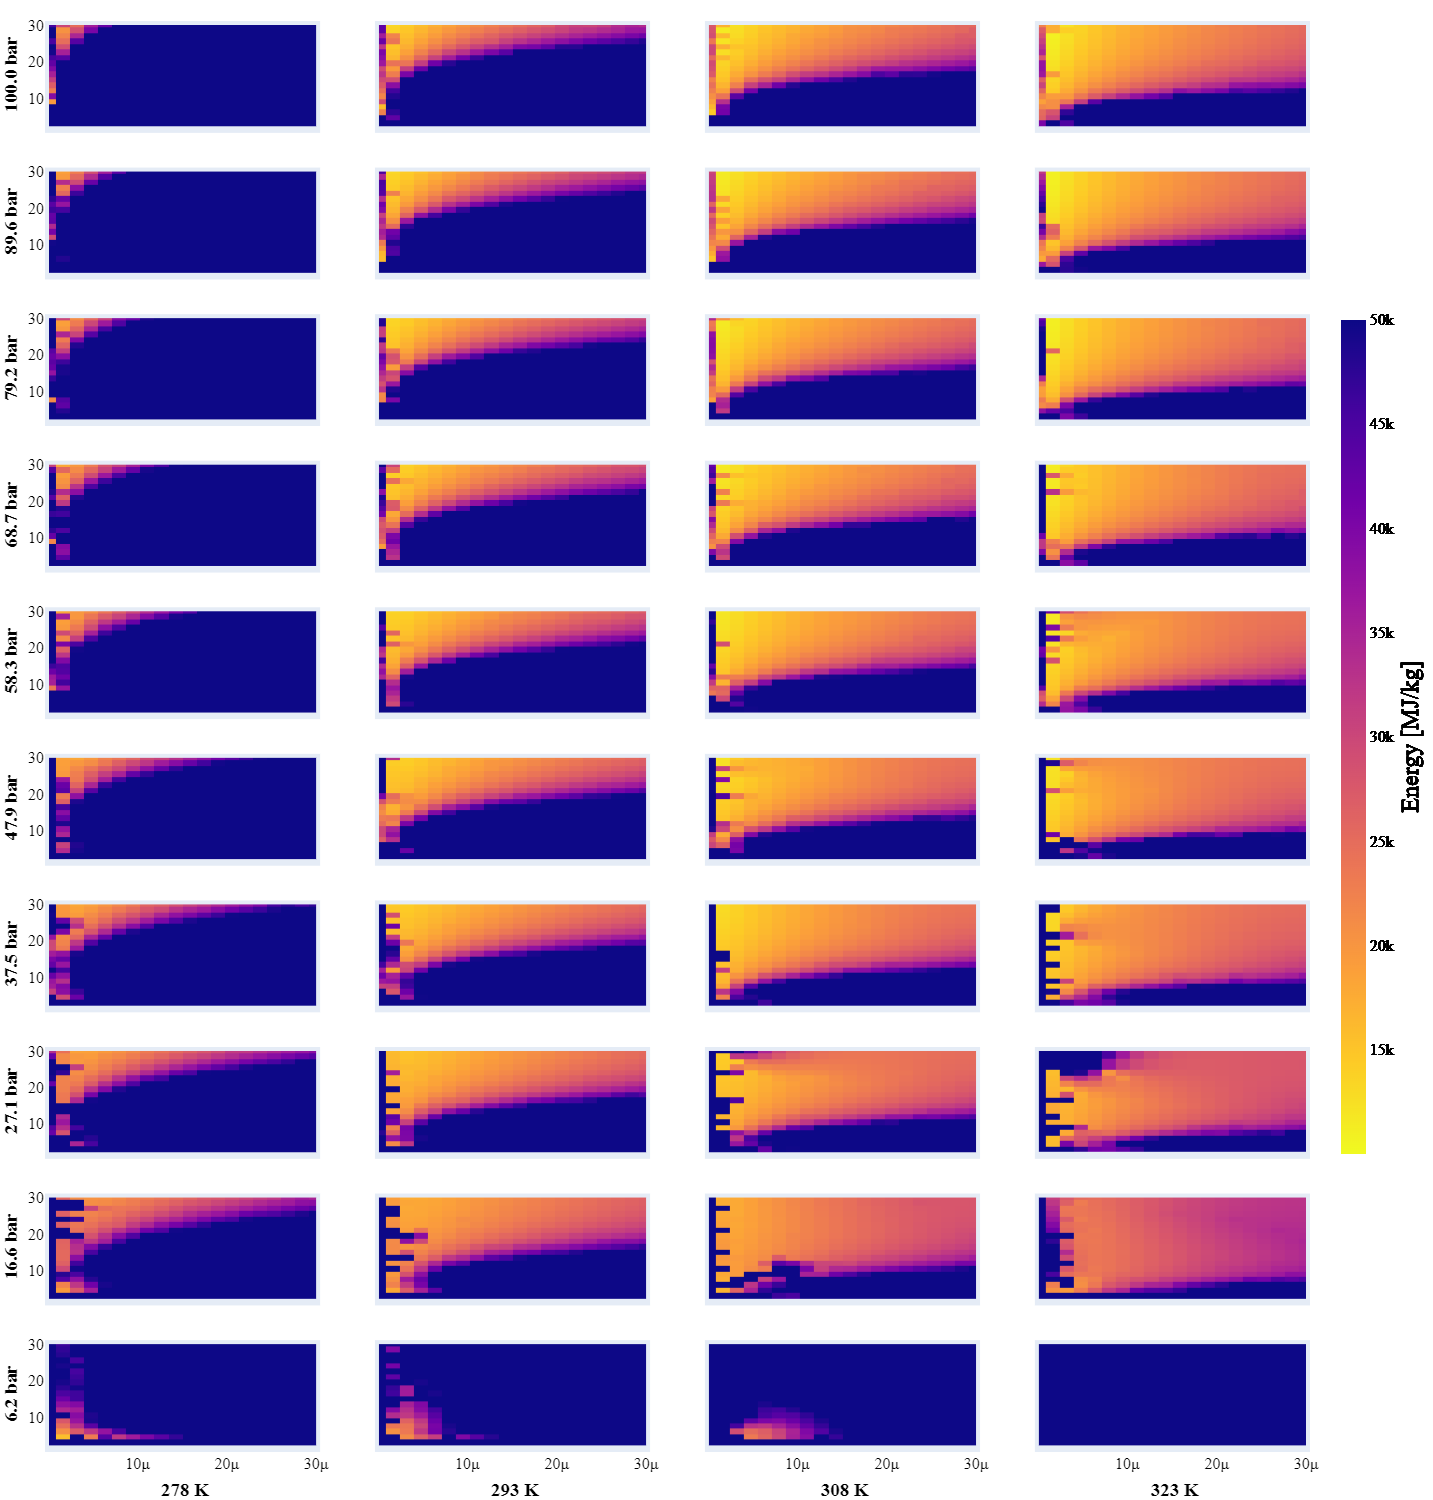

In [84]:
"""4D plot"""

# other params
alfa_M = 0.05
index = de.par_indexOfArgon
surfactant = 0.5

# axis ranges
R_E_range = [parameter_ranges[parameters.index('R_E')][0], parameter_ranges[parameters.index('R_E')][-1]]
ratio_range = [parameter_ranges[parameters.index('R_0/R_E')][0], parameter_ranges[parameters.index('R_0/R_E')][-1]]
T_inf_range = [parameter_ranges[parameters.index('T_inf')][0], parameter_ranges[parameters.index('T_inf')][-1]]
P_inf_range = [parameter_ranges[parameters.index('P_inf')][0], parameter_ranges[parameters.index('P_inf')][-1]]

# subplot
cols = len(parameter_ranges[parameters.index('T_inf')])
rows = len(P_inf_to_plot)#len(parameter_ranges[parameters.index('P_inf')])
rows = min(rows, 20)
cols = min(cols, 20)
fig = make_subplots(
    rows=rows, cols=cols,
    start_cell="bottom-left",
)

for row in range(rows):
    P_inf = P_inf_to_plot[row]#parameter_ranges[parameters.index('P_inf')][row]
    for col in range(cols):
        T_inf = parameter_ranges[parameters.index('T_inf')][col]
        
        # select data
        disp = good_data.loc[
            (good_data['R_0/R_E'] > ratio_range[0]) &
            (abs(good_data['P_inf']-P_inf) < 100) &
            (good_data['alfa_M'] == alfa_M) &
            (good_data['T_inf'] == T_inf) &
            (good_data['index'] == index) &
            (good_data['surfactant'] == surfactant)
        ]
        
        # plot
        data = go.Heatmap(
                x=disp['R_E'],
                y=disp['R_0/R_E'],
                z=disp['Energy'],
                colorscale='Plasma_r',
                zmin=good_data.iloc[1]['Energy'], zmax=50e3,
                #zsmooth='best',
                connectgaps=True,
                colorbar=dict(
                    title='Energy [MJ/kg]',
                    titleside='right',
                    thickness=25,
                    thicknessmode='pixels',
                    len=0.6,
                    lenmode='fraction',
                    outlinewidth=0,
                    titlefont=dict(color='black', family='Open Sans', size=24),
                )
        )
        
        fig.add_trace(data,
              row=row+1, col=col+1)
        
        # Update axis properties
        fig.update_xaxes(range=R_E_range, showgrid=False, zeroline=False, visible=False, row=row+1, col=col+1)
        fig.update_yaxes(range=ratio_range, showgrid=False, zeroline=False, visible=False, row=row+1, col=col+1)
        if row==0:
            #fig.update_xaxes(title=f'<b>{(1e-5*P_inf): .1f} bar</b>', visible=True, row=1, col=col+1)
            fig.update_xaxes(title=f'<b>{T_inf: .0f} K</b>', visible=True, row=1, col=col+1)
    #fig.update_yaxes(title=f'<b>{T_inf: .0f} K</b>', visible=True, row=row+1, col=1)
    fig.update_yaxes(title=f'<b>{(1e-5*P_inf): .1f} bar</b>', visible=True, row=row+1, col=1)

# Layout
fig.update_layout(
    font=dict(color='black', family='Open Sans', size=16),
    #title_text="Energy required for hydrogen production",
    autosize=False,
    width=150*cols, height=150*rows,
    margin=go.layout.Margin(
        l=0,
        r=0,
        b=0,
        t=25,
        pad = 4
    ),
)

fig.show()
#fig.write_image("images/4Dplot.png")

In [3]:
"""Find parameter combinations with an error"""

# Equilibrium radius [um --> m]
R_E_list = [1e-6*x for x in np.linspace(0.1, 30.0, 20)]
# R_star / R_E [-]
ratio_list = np.linspace(1.5, 30.0, 20)
# Ambient pressure [Pa]
P_inf_list = [1e5*x for x in np.linspace(1.0, 100.0, 20)]
# Accommodation coeff. for evaporation [-]
alfa_M_list = [0.05, 0.15, 0.25, 0.35]
# Ambient temperature [°C --> K]
T_inf_list = [273.15+x for x in [5.0, 20.0, 35.0, 50.0]]
# Surface tension modifier [-]
surfactant_list = [0.25, 0.5, 0.75, 1.0]
# Index of neutral gas [Ar: 9; He: 10]
index_list = [9, 10]

print(f'R_E: {len(R_E_list)}')
print(f'ratio: {len(ratio_list)}')
print(f'P_inf: {len(P_inf_list)}')
print(f'alfa_M: {len(alfa_M_list)}')
print(f'T_inf: {len(T_inf_list)}')
print(f'surfactant: {len(surfactant_list)}')
print(f'index: {len(index_list)}')
print(f'total combinations: {len(R_E_list) * len(ratio_list) * len(P_inf_list) * len(alfa_M_list) * len(T_inf_list) * len(surfactant_list) *len(index_list)}')

parameters = []
ID = 0
for R_E in R_E_list:
    df1 = all_data.loc[abs(all_data['R_E']-R_E)<1e-8]
    for ratio in ratio_list:
        df2 = df1.loc[abs(df1['R_0/R_E']-ratio)<1e-3]
        for P_inf in P_inf_list:
            df3 = df2.loc[abs(df2['P_inf']-P_inf)<1.0]
            print(f'{ID}   ', end='\r')
            for alfa_M in alfa_M_list:
                df4 = df3.loc[abs(df3['alfa_M']-alfa_M)<0.001]
                for T_inf in T_inf_list:
                    for surfactant in surfactant_list:
                        for index in index_list:
                            df = df4.loc[
                                ((df4['T_inf']-T_inf)<0.001) &
                                ((df4['surfactant']-surfactant)<0.001) &
                                ((df4['index']-index)<0.01)
                            ]
                            if df.empty:
                                P_v = de.VapourPressure(T_inf)
                                parameters.append([ID, R_E, ratio, P_inf, alfa_M, T_inf, P_v, index, surfactant])
                            ID += 1

R_E: 20
ratio: 20
P_inf: 20
alfa_M: 4
T_inf: 4
surfactant: 4
index: 2
total combinations: 1024000


In [28]:
disp = all_data.loc[all_data['Energy'] != all_data['Energy']]
print_as_list(disp[:10])

[
    # ID, R_E, R_0/R_E, P_inf, alfa_M, T_inf, vapour pressure, index, surfactant, 
    [0.0, 1.4263157894736843e-05, 30.0, 5310526.315789473, 0.05, 323.15, 12349.40351028322, 9.0, 0.75],    # error code=0.0;   Energy=nan [MJ/kg]
    [0.0, 1.4263157894736843e-05, 4.5, 8957894.736842105, 0.15, 278.15, 872.4400336372915, 10.0, 0.5],    # error code=0.0;   Energy=nan [MJ/kg]
    [0.0, 1.5836842105263155e-05, 25.5, 7394736.842105263, 0.35, 308.15, 5626.752063676547, 9.0, 0.75],    # error code=0.0;   Energy=nan [MJ/kg]
    [0.0, 4.821052631578946e-06, 12.0, 1663157.8947368418, 0.25, 323.15, 12349.40351028322, 9.0, 0.5],    # error code=0.0;   Energy=nan [MJ/kg]
    [0.0, 3e-05, 25.5, 3226315.7894736836, 0.05, 323.15, 12349.40351028322, 10.0, 1.0],    # error code=0.0;   Energy=nan [MJ/kg]
    [0.0, 3.247368421052632e-06, 19.5, 2705263.157894737, 0.15, 293.15, 2338.339978450019, 10.0, 0.75],    # error code=0.0;   Energy=nan [MJ/kg]
    [0.0, 1.5836842105263155e-05, 4.5, 4789473.684210526,